In [2]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 2.1MB 18.8MB/s 
     |████████████████████████████████| 225kB 55.8MB/s 
     |████████████████████████████████| 3.3MB 56.0MB/s 
     |████████████████████████████████| 901kB 55.4MB/s 
     |████████████████████████████████| 245kB 61.1MB/s 
     |████████████████████████████████| 112kB 26.9MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [5]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["validation"]

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [6]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части 

(`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][1])

['i',
 'Ġcan',
 'Ġgo',
 'Ġfrom',
 'Ġfeeling',
 'Ġso',
 'Ġhopeless',
 'Ġto',
 'Ġso',
 'Ġdamned',
 'Ġhopeful',
 'Ġjust',
 'Ġfrom',
 'Ġbeing',
 'Ġaround',
 'Ġsomeone',
 'Ġwho',
 'Ġcares',
 'Ġand',
 'Ġis',
 'Ġawake']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь
# b = tokenizer.encode_plus(
#     emotion_dataset["train"]["text"][0], 
#     max_length=128, # максимальная длина текста
#     padding="max_length", # надо ли добавлять паддинг в конце?
#     return_tensors="pt", # возвращает pytorch тензоры
# )
# b['input_ids']

In [7]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, padding="max_length", max_length=100, return_tensors="pt") #padding="max_length"  self.max_length,
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [8]:
train_dataset = TweetDataset("train", emotion_dataset, tokenizer)
valid_dataset = TweetDataset("validation", emotion_dataset, tokenizer) # validation
test_dataset = TweetDataset("test", emotion_dataset, tokenizer)

In [9]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size,
    shuffle=True
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = train_dataset[0]['input_ids'] # Получи токены из датасета
mask = train_dataset[0]['mask'] # Получи маску из датасета

output = model_0(input_ids = tokens.to(device), attention_mask = mask.to(device)) # Посмотри на аутпут
output.logits

tensor([[ 0.6455,  0.0061, -0.0810, -0.4484, -0.6968, -0.3081]],
       device='cuda:0', grad_fn=<IndexBackward>)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm

num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        tokens = batch["input_ids"]
        tokens = tokens.view(tokens.shape[0], tokens.shape[2])
        mask = batch["mask"]
        mask = mask.view(mask.shape[0], mask.shape[2])
        output = model_0(input_ids = tokens.to(device), attention_mask = mask.to(device))
        pred = output.logits
        trg = batch["target"]
        loss = criterion(pred, trg.to(device))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch["input_ids"]
            mask = batch["mask"]
            tokens = tokens.view(tokens.shape[0], tokens.shape[2])
            mask = mask.view(mask.shape[0], mask.shape[2])
            output = model_0(input_ids = tokens.to(device), attention_mask = mask.to(device))
            pred = output.logits
            trg = (batch["target"]).to(device)
            loss = criterion(pred, trg)
            pred_trg = pred.argmax(dim=1).cpu().numpy()
            real_trg = trg.cpu().numpy()
            predict = np.array(pred_trg == real_trg)
            #print(a)
            valid_acc += (np.sum(predict)/tokens.shape[0])
            valid_loss += loss.item()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch["input_ids"]
        mask = batch["mask"]
        tokens = tokens.view(tokens.shape[0], tokens.shape[2])
        mask = mask.view(mask.shape[0], mask.shape[2])
        output = model_0(input_ids = tokens.to(device), attention_mask = mask.to(device))
        pred = output.logits
        trg = (batch["target"]).to(device)
        loss = criterion(pred, trg)
        pred_trg = pred.argmax(dim=1).cpu().numpy()
        real_trg = trg.cpu().numpy()
        predict = np.array(pred_trg == real_trg)
        test_acc += (np.sum(predict)/tokens.shape[0])
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.279149149775505,Valid Loss: 0.47098052222281694,Valid Acc: 0.84619140625



Train Loss: 0.27998016819357874,Valid Loss: 0.30909061059355736,Valid Acc: 0.8896484375



Train Loss: 0.12702631264179945,Valid Loss: 0.28370202146470547,Valid Acc: 0.90283203125



Train Loss: 0.08553155558183789,Valid Loss: 0.33098788536153734,Valid Acc: 0.88916015625



Train Loss: 0.0639374641943723,Valid Loss: 0.34011909551918507,Valid Acc: 0.900390625
Test Acc: 0.888671875


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [16]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq

In [17]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][1] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

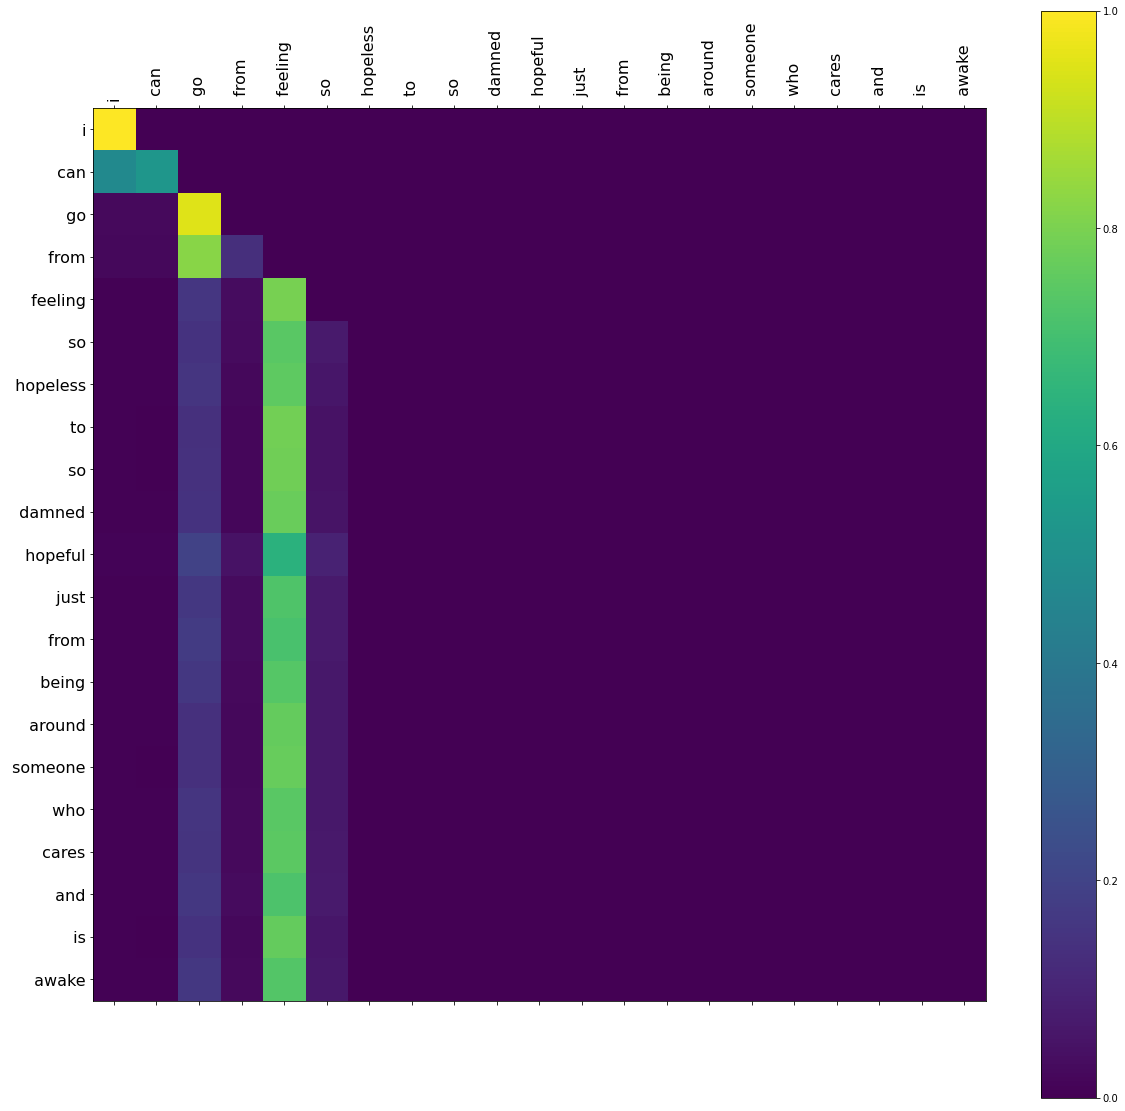

In [ ]:
attns, seq = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [10]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [13]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        tokens = batch["input_ids"]
        tokens = tokens.view(tokens.shape[0], tokens.shape[2])
        mask = batch["mask"]
        mask = mask.view(mask.shape[0], mask.shape[2])
        output = model_1(input_ids = tokens.to(device), attention_mask = mask.to(device))
        pred = output.logits
        trg = batch["target"]
        loss = criterion(pred, trg.to(device))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch["input_ids"]
            mask = batch["mask"]
            tokens = tokens.view(tokens.shape[0], tokens.shape[2])
            mask = mask.view(mask.shape[0], mask.shape[2])
            output = model_1(input_ids = tokens.to(device), attention_mask = mask.to(device))
            pred = output.logits
            trg = (batch["target"]).to(device)
            loss = criterion(pred, trg)
            pred_trg = pred.argmax(dim=1).cpu().numpy()
            real_trg = trg.cpu().numpy()
            predict = np.array(pred_trg == real_trg)
            #print(a)
            valid_acc += (np.sum(predict)/tokens.shape[0])
            valid_loss += loss.item()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch["input_ids"]
        mask = batch["mask"]
        tokens = tokens.view(tokens.shape[0], tokens.shape[2])
        mask = mask.view(mask.shape[0], mask.shape[2])
        output = model_1(input_ids = tokens.to(device), attention_mask = mask.to(device))
        pred = output.logits
        trg = (batch["target"]).to(device)
        loss = criterion(pred, trg)
        pred_trg = pred.argmax(dim=1).cpu().numpy()
        real_trg = trg.cpu().numpy()
        predict = np.array(pred_trg == real_trg)
        test_acc += (np.sum(predict)/tokens.shape[0])
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.6614923548698426,Valid Loss: 1.287459570914507,Valid Acc: 0.55712890625



Train Loss: 0.79302499294281,Valid Loss: 0.40601646900177,Valid Acc: 0.8603515625



Train Loss: 0.3724814563989639,Valid Loss: 0.24621530307922512,Valid Acc: 0.90966796875



Train Loss: 0.2523148787766695,Valid Loss: 0.2039742865599692,Valid Acc: 0.923828125



Train Loss: 0.20215486273169517,Valid Loss: 0.17436862498288974,Valid Acc: 0.92431640625
Test Acc: 0.92041015625


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [14]:
text = emotion_dataset["train"]["text"][1] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

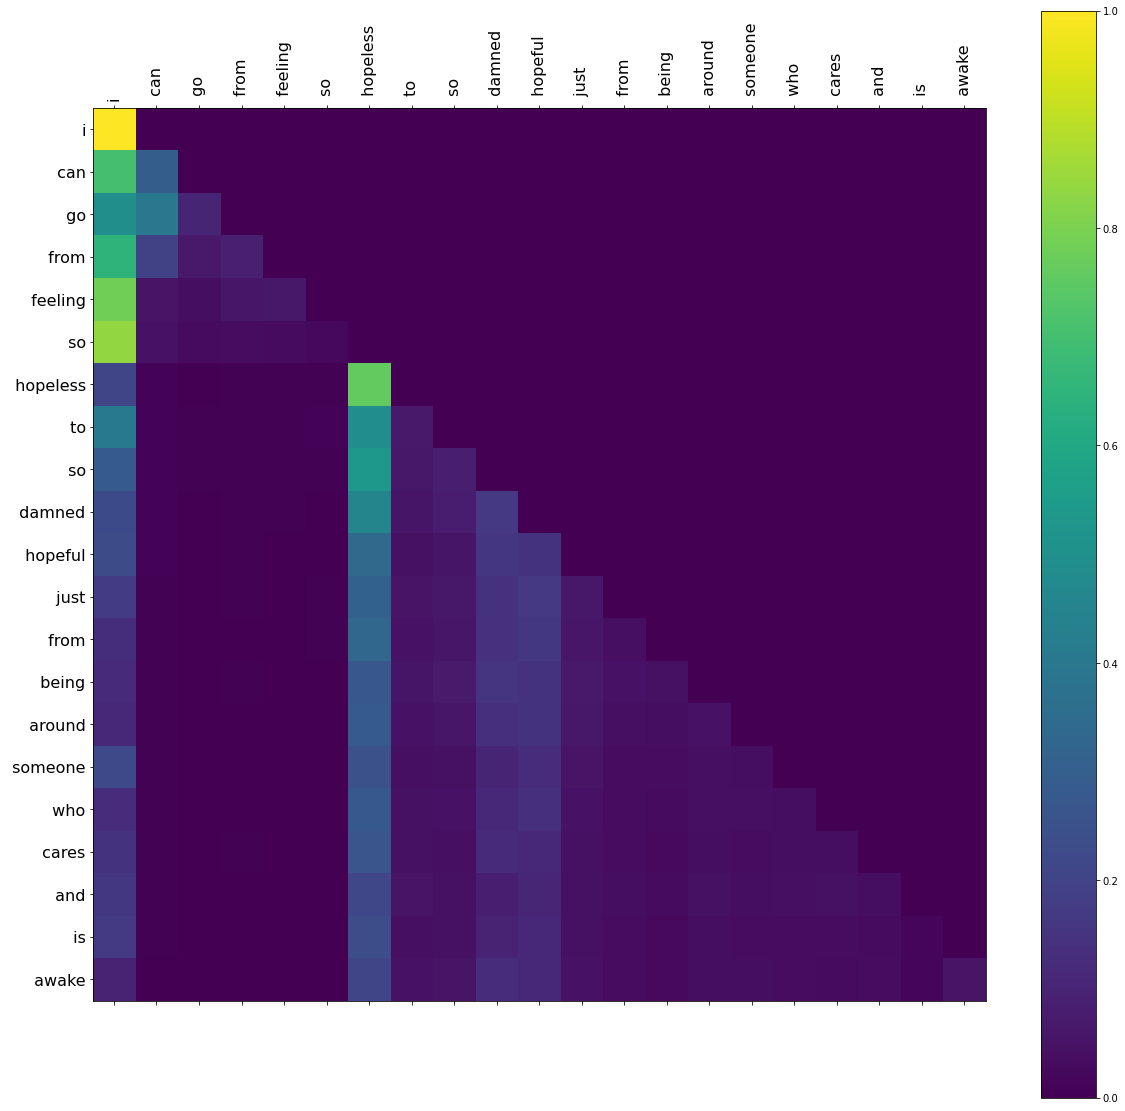

In [20]:
attns, seq = get_attention_matrixes(model_1, tokenizer, text)
show_attention(seq, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

1.   Подход, при котором использовалась модель, обученная решать задачу Language Modeling оказался лучше.
2.   so, hopeless, to, feeling
3.   


